## Problem Statement

A user is looking for loans on Google and enters a search query. Depending on how related the search query is to the business, we choose to bid for the query with the goal of maximizing the user impressions using Google Adwords (Google actually showing the ad to the user when they execute the search). This would lead to more clicks on ads, and potentially more signups, activations, and revenue. Here activation is defined as a user successfully contacted by the call center.

The dataset contains ~94k rows and the following variables.

### <center> Data dictionary </center>
|Variable|	Description|
|:---|:---|
|created_date|date on which the click was recorded|
|location_in_query|city name that appeared in search query|
|platform|platform such as web/mobile|
|campaign_state|US state where the ad campaign was run|
|in_city|whether the ad campaign was run in a city or not|
|is_prime|whether the word fico prime appeared in the search query|
|is_hardship|whether the word hardship appeared in the search query|
|category_debt_type|type of debt solution that appeared in the search query|
|is_activated|(Target) whether the user talked to the call center or not|

The objective here is to build a model that predicts the probability of activation per click

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import xgboost as xgb #Extreme Gradient Boosting Model
from xgboost import plot_tree #For tree visualization
import matplotlib.pyplot as plt #For plotting graphs
plt.style.use('ggplot')
#include plots in the notebook
%matplotlib inline 
import seaborn as sns #For plotting graphs
#sns.set(style='darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #for creating dummy variables out of categorical variables
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve #For model evaluation
from sklearn.model_selection import GridSearchCV #for tuning model hyperparameters
from sklearn import metrics #metrics for model evaluation
from sklearn.impute import KNNImputer #for imputing missing values using K nearest neighbor algorithm
from xgboost import plot_importance
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import collections


# Undersampling and Oversampling Libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour,TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

### Import data

In [2]:
rawdata = pd.read_csv('clicks-activation_v2.csv')
inputdata = rawdata

In [3]:
inputdata.head()

,created_date,location_in_query,platform,campaign_state,in_city,is_prime,is_hardship,is_activated,category_debt_type
0,12/27/2017,san antonio,mobile web,tx,1,0,0,True,debt_settlement
1,1/10/2018,honolulu,mobile web,hi,0,0,0,False,debt_settlement
2,12/15/2017,atlanta,desktop web,ga,1,0,0,True,debt_settlement
3,1/6/2018,honolulu,mobile web,hi,0,0,0,False,debt_settlement
4,12/20/2017,South Beachmi,mobile web,fl,0,0,0,False,cash_loan


In [4]:
inputdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94194 entries, 0 to 94193
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_date        94194 non-null  object
 1   location_in_query   94179 non-null  object
 2   platform            94194 non-null  object
 3   campaign_state      94188 non-null  object
 4   in_city             94194 non-null  int64 
 5   is_prime            94194 non-null  int64 
 6   is_hardship         94194 non-null  int64 
 7   is_activated        94194 non-null  bool  
 8   category_debt_type  84335 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 5.8+ MB


In [5]:
inputdata.describe().T

,count,mean,std,min,25%,50%,75%,max
in_city,94194.0,0.506911,0.499955,0.0,0.0,1.0,1.0,1.0
is_prime,94194.0,0.021604,0.145389,0.0,0.0,0.0,0.0,1.0
is_hardship,94194.0,0.300093,0.458301,0.0,0.0,0.0,1.0,1.0


In [6]:
inputdata.groupby(['is_activated']).size()

is_activated
False    87407
True      6787
dtype: int64

In [7]:
#check for duplicates
inputdata1 = inputdata[inputdata.duplicated(keep="first")]

In [8]:
inputdata1.groupby(['is_activated']).size()

is_activated
False    70526
True      2938
dtype: int64

In [9]:
inputdata1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73464 entries, 125 to 94193
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_date        73464 non-null  object
 1   location_in_query   73463 non-null  object
 2   platform            73464 non-null  object
 3   campaign_state      73464 non-null  object
 4   in_city             73464 non-null  int64 
 5   is_prime            73464 non-null  int64 
 6   is_hardship         73464 non-null  int64 
 7   is_activated        73464 non-null  bool  
 8   category_debt_type  65358 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 5.1+ MB


There are no duplicates in the dataset

### Exploratory Data Analysis

In [10]:
# Check missing data
total = rawdata.isnull().sum().sort_values(ascending=False)
percent = (rawdata.isnull().sum()/inputdata.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
category_debt_type,9859,0.104667
location_in_query,15,0.000159
campaign_state,6,0.000064
created_date,0,0.000000
platform,0,0.000000
in_city,0,0.000000
is_prime,0,0.000000
is_hardship,0,0.000000
is_activated,0,0.000000


In [11]:
#fill missing values for the following
inputdata["category_debt_type"].fillna("Missing", inplace = True)
inputdata["location_in_query"].fillna("Missing", inplace = True)
inputdata["campaign_state"].fillna("Missing", inplace = True)

In [12]:
# Convert created date to datetime object
inputdata['created_date'] = pd.to_datetime(inputdata['created_date'],format="%m/%d/%Y")
inputdata['created_day'] = inputdata['created_date'].dt.day
inputdata['created_month'] = inputdata['created_date'].dt.month
inputdata['created_year'] = inputdata['created_date'].dt.year
inputdata['created_date1'] = inputdata['created_year']*10000+inputdata['created_month']*100+inputdata['created_day']
inputdata['created_day_name'] = inputdata['created_date'].dt.day_name()

In [13]:
print('Min date :', inputdata.created_date1.min(), \
      'Max date :', inputdata.created_date1.max())

Min date : 20171212 Max date : 20180112


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, '20171212'),
  Text(1, 0, '20171213'),
  Text(2, 0, '20171214'),
  Text(3, 0, '20171215'),
  Text(4, 0, '20171216'),
  Text(5, 0, '20171217'),
  Text(6, 0, '20171218'),
  Text(7, 0, '20171219'),
  Text(8, 0, '20171220'),
  Text(9, 0, '20171221'),
  Text(10, 0, '20171222'),
  Text(11, 0, '20171223'),
  Text(12, 0, '20171224'),
  Text(13, 0, '20171225'),
  Text(14, 0, '20171226'),
  Text(15, 0, '20171227'),
  Text(16, 0, '20171228'),
  Text(17, 0, '20171229'),
  Text(18, 0, '20171230'),
  Text(19, 0, '20171231'),
  Text(20, 0, '20180101'),
  Text(21, 0, '20180102'),
  Text(22, 0, '20180103'),
  Text(23, 0, '20180104'),
  Text(24, 0, '20180105'),
  Text(25, 0, '20180106'),
  Text(26, 0, '20180107'),
  Text(27, 0, '20180108'),
  Text(28, 0, '20180109'),
  Text(29, 0, '20180110'),
  Text(30, 0, '20180111'),
  Text(31, 0, '20180112')])

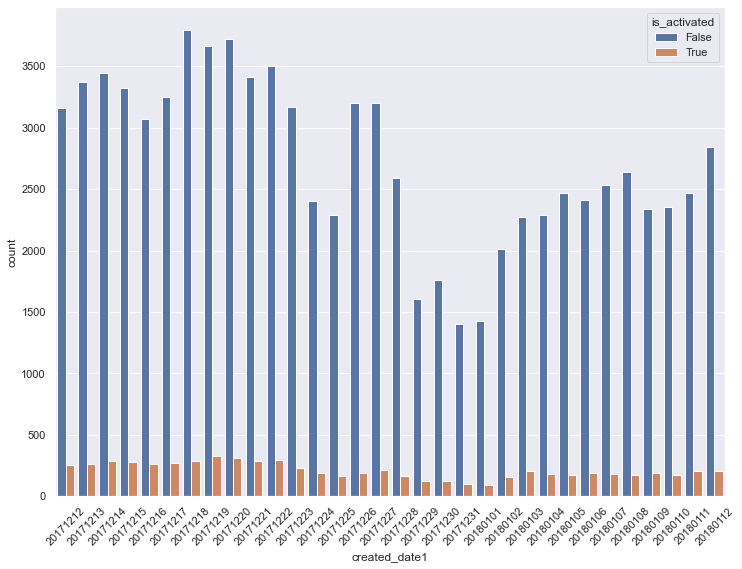

In [14]:
sns.set(rc={'figure.figsize':(12,9)})
fig1 = sns.countplot(inputdata['created_date1'],hue=inputdata["is_activated"])
plt.xticks(rotation=45)

In [15]:
inputdata

,created_date,location_in_query,platform,campaign_state,in_city,is_prime,is_hardship,is_activated,category_debt_type,created_day,created_month,created_year,created_date1,created_day_name
0,2017-12-27,san antonio,mobile web,tx,1,0,0,True,debt_settlement,27,12,2017,20171227,Wednesday
1,2018-01-10,honolulu,mobile web,hi,0,0,0,False,debt_settlement,10,1,2018,20180110,Wednesday
2,2017-12-15,atlanta,desktop web,ga,1,0,0,True,debt_settlement,15,12,2017,20171215,Friday
3,2018-01-06,honolulu,mobile web,hi,0,0,0,False,debt_settlement,6,1,2018,20180106,Saturday
4,2017-12-20,South Beachmi,mobile web,fl,0,0,0,False,cash_loan,20,12,2017,20171220,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94189,2017-12-22,honolulu,desktop web,hi,1,0,0,False,debt_settlement,22,12,2017,20171222,Friday
94190,2017-12-26,saint petersburg,mobile web,fl,1,0,1,False,debt_settlement,26,12,2017,20171226,Tuesday
94191,2018-01-09,saint louis,desktop web,mo,1,0,1,False,debt_settlement,9,1,2018,20180109,Tuesday
94192,2017-12-19,jonesboro,mobile web,ga,0,0,0,False,debt_settlement,19,12,2017,20171219,Tuesday


In [16]:
pd.pivot_table(inputdata, index='created_date', values=['is_activated'],aggfunc=['count','sum','mean']).head()

,count,sum,mean
,is_activated,is_activated,is_activated
created_date,,,
2017-12-12,3419,259,0.075753
2017-12-13,3635,260,0.071527
2017-12-14,3731,287,0.076923
2017-12-15,3601,280,0.077756
2017-12-16,3336,263,0.078837


Text(0, 0.5, 'Activation Rate')

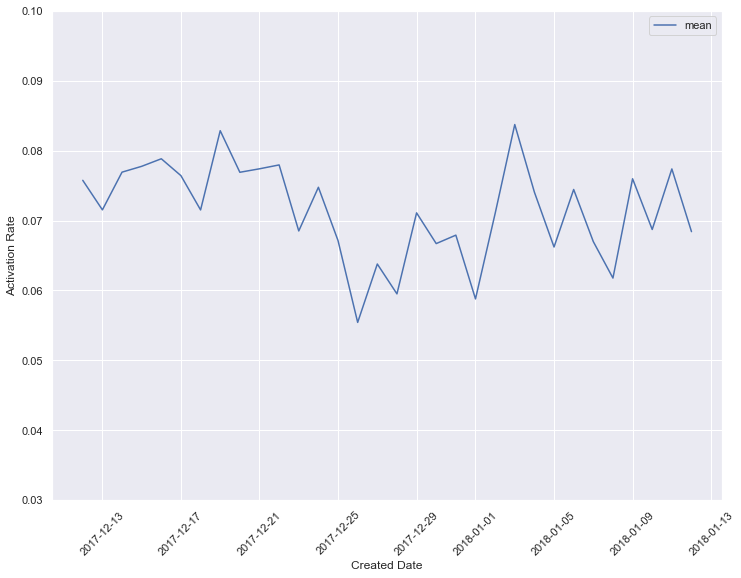

In [17]:
sns.set(rc={'figure.figsize':(12,9)})
pivot1 = pd.pivot_table(inputdata, index='created_date', values=['is_activated'],aggfunc=['mean'])\
.rename(columns={'is_activated': 'activation_rate'})
sns.lineplot(data=pivot1)
plt.xticks(rotation=45)
plt.ylim((0.03, 0.1))
plt.xlabel("Created Date")
plt.ylabel("Activation Rate")

Text(0.5, 1.0, 'Activation Rate by Weekday')

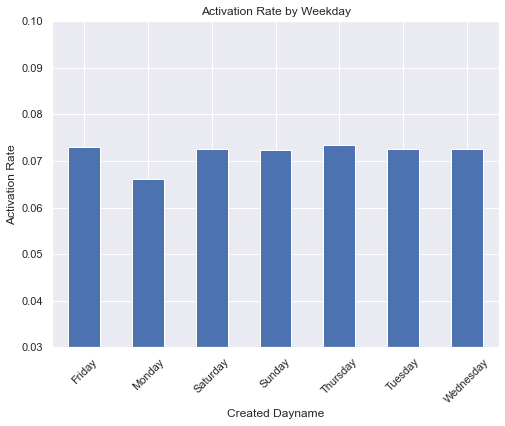

In [18]:
sns.set(rc={'figure.figsize':(8,6)})
pd.pivot_table(inputdata, index='created_day_name', values=['is_activated'],aggfunc=['mean'])\
.rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
#sns.barplot(data=pivot2)
plt.xticks(rotation=45)
#plt.gca().set_xticklabels(train['created_date'])
plt.ylim((0.03, 0.1))
plt.xlabel("Created Dayname")
plt.ylabel("Activation Rate")
plt.legend([],[], frameon=False)
plt.title("Activation Rate by Weekday")
#Although it appears that there is lower activation rate on Monday, \
#there are only 4 data points over the span of a month. Therefore, this feature is not suitable for modeling

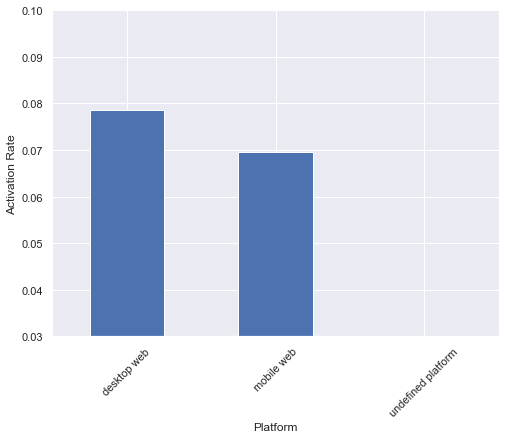

In [19]:
sns.set(rc={'figure.figsize':(8,6)})
pivot2 = pd.pivot_table(inputdata, index='platform', values=['is_activated'],aggfunc=['mean'])\
                    .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=45)
plt.ylim((0.03, 0.1))
plt.xlabel("Platform")
plt.ylabel("Activation Rate")
plt.legend([],[], frameon=False)

In [20]:
pd.pivot_table(inputdata, index='category_debt_type', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,mean
,activation_rate
category_debt_type,
Missing,0.086216
cash_loan,0.038168
cheap_loan,0.046154
debt_settlement,0.072501
mortgage_refi,0.059588


,count,sum,mean
,activation_rate,activation_rate,activation_rate
category_debt_type,,,
Missing,9859,850,0.086216
cash_loan,4323,165,0.038168
cheap_loan,195,9,0.046154
debt_settlement,77971,5653,0.072501
mortgage_refi,1846,110,0.059588


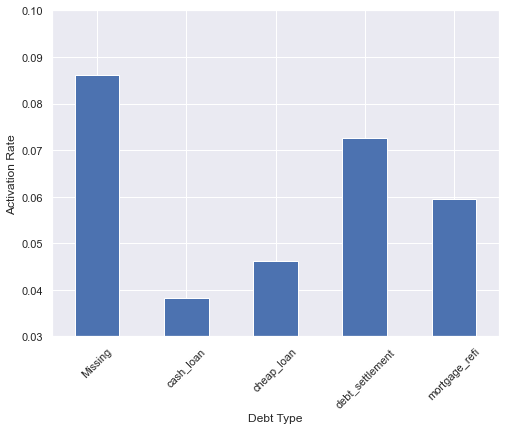

In [21]:
#inputdata.loc[inputdata["category_debt_type"].isin(""), "campaign_state"] = "others"
sns.set(rc={'figure.figsize':(8,6)})
pd.pivot_table(inputdata, index='category_debt_type', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=45)
plt.xlabel("Debt Type")
plt.ylabel("Activation Rate")
plt.ylim((0.03, 0.1))
plt.legend([],[], frameon=False)
pd.pivot_table(inputdata, index='category_debt_type', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,count,sum,mean
,activation_rate,activation_rate,activation_rate
in_city,,,
0,46446,3172,0.068294
1,47748,3615,0.075710


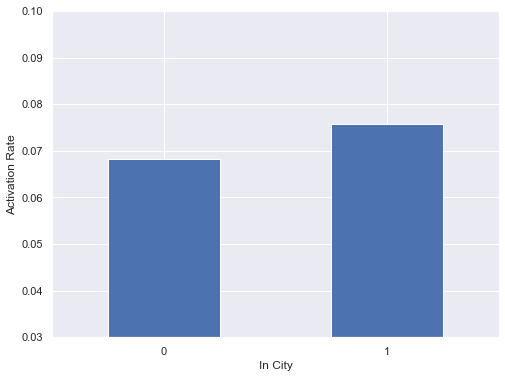

In [22]:
sns.set(rc={'figure.figsize':(8,6)})
pd.pivot_table(inputdata, index='in_city', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("In City")
plt.ylabel("Activation Rate")
plt.ylim((0.03, 0.1))
plt.legend([],[], frameon=False)
pd.pivot_table(inputdata, index='in_city', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,count,sum,mean
,activation_rate,activation_rate,activation_rate
is_prime,,,
0,92159,6523,0.07078
1,2035,264,0.12973


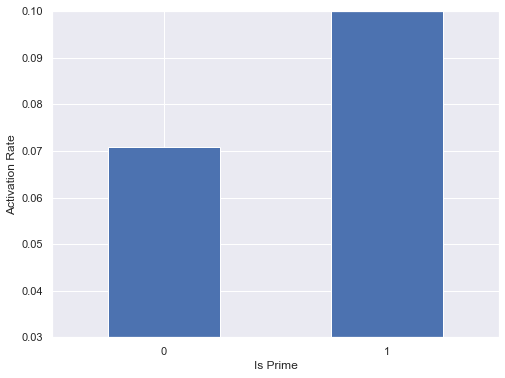

In [23]:
sns.set(rc={'figure.figsize':(8,6)})
pd.pivot_table(inputdata, index='is_prime', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("Is Prime")
plt.ylabel("Activation Rate")
plt.ylim((0.03, 0.1))
plt.legend([],[], frameon=False)
pd.pivot_table(inputdata, index='is_prime', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,count,sum,mean
,activation_rate,activation_rate,activation_rate
is_hardship,,,
0,65927,4828,0.073233
1,28267,1959,0.069303


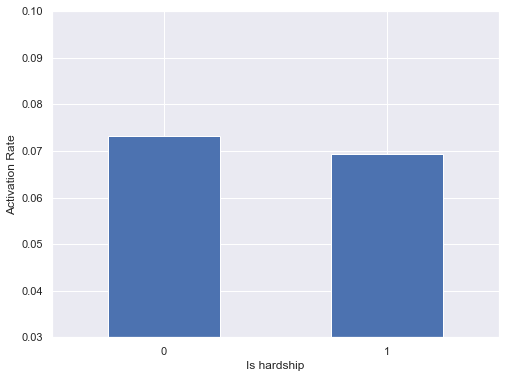

In [24]:
sns.set(rc={'figure.figsize':(8,6)})
pd.pivot_table(inputdata, index='is_hardship', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("Is hardship")
plt.ylabel("Activation Rate")
plt.ylim((0.03, 0.1))
plt.legend([],[], frameon=False)
pd.pivot_table(inputdata, index='is_hardship', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

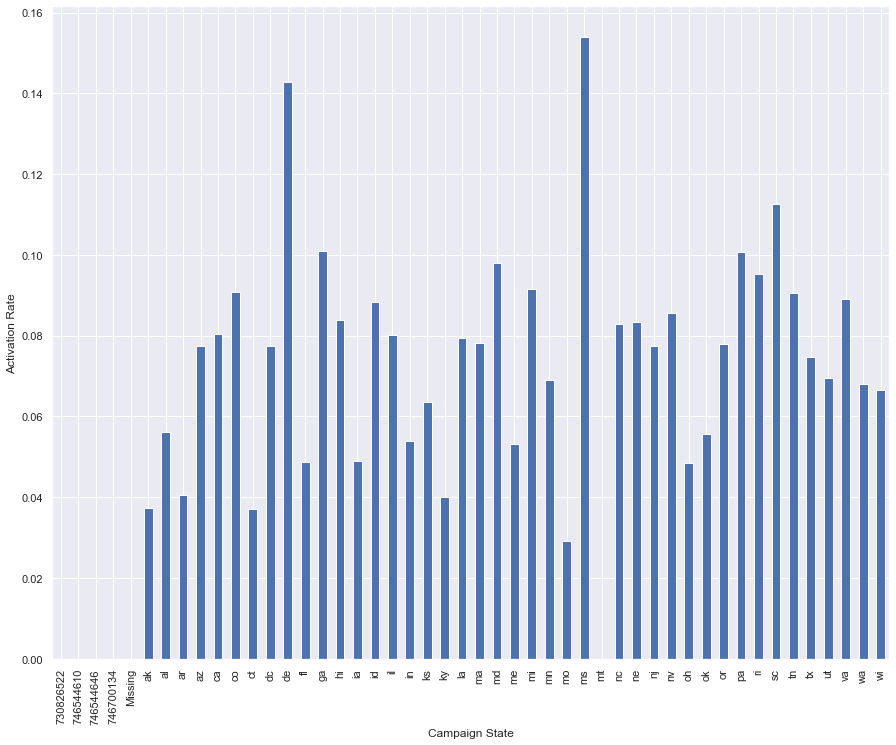

In [25]:
sns.set(rc={'figure.figsize':(15,12)})
pd.pivot_table(inputdata, index='campaign_state', values=['is_activated'],aggfunc=['mean'])\
                            .rename(columns={'is_activated': 'activation_rate'}).plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel("Campaign State")
plt.ylabel("Activation Rate")
#plt.ylim((0.03, 0.1))
plt.legend([],[], frameon=False)
states = pd.pivot_table(inputdata, index='campaign_state', values=['is_activated'],aggfunc=['count'])
                        

In [26]:
#Group States into 'others' category where the counts are < 25
list = inputdata.groupby(['campaign_state']).size()
state_list = list[list>=25].index.tolist()
state_list
# Replaces state names with others if not in the above list
inputdata.loc[~inputdata["campaign_state"].isin(state_list), "campaign_state"] = "others"
pd.pivot_table(inputdata, index='campaign_state', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,count,sum,mean
,activation_rate,activation_rate,activation_rate
campaign_state,,,
ak,107,4,0.037383
al,232,13,0.056034
ar,74,3,0.040541
az,4164,322,0.077329
ca,15494,1246,0.080418
co,5389,489,0.090740
ct,81,3,0.037037
dc,1225,95,0.077551


### Feature Engineering

In [27]:
# Replace different spelling for the same city with the most occuring version
inputdata['location_in_query'] = inputdata['location_in_query'].replace({'LA':'los angeles','Denverver':'denver'})
inputdata[inputdata['location_in_query'] =='denver']

,created_date,location_in_query,platform,campaign_state,in_city,is_prime,is_hardship,is_activated,category_debt_type,created_day,created_month,created_year,created_date1,created_day_name
18,2018-01-02,denver,mobile web,co,0,0,0,True,debt_settlement,2,1,2018,20180102,Tuesday
26,2018-01-01,denver,mobile web,co,0,0,0,False,debt_settlement,1,1,2018,20180101,Monday
32,2017-12-12,denver,desktop web,co,0,0,0,False,debt_settlement,12,12,2017,20171212,Tuesday
40,2017-12-22,denver,mobile web,co,1,0,1,False,debt_settlement,22,12,2017,20171222,Friday
41,2018-01-04,denver,mobile web,co,1,0,1,True,debt_settlement,4,1,2018,20180104,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94147,2018-01-12,denver,mobile web,co,0,0,0,False,debt_settlement,12,1,2018,20180112,Friday
94163,2018-01-09,denver,mobile web,co,0,0,0,False,debt_settlement,9,1,2018,20180109,Tuesday
94165,2018-01-12,denver,mobile web,co,0,0,0,False,Missing,12,1,2018,20180112,Friday
94170,2018-01-11,denver,mobile web,co,0,0,0,False,debt_settlement,11,1,2018,20180111,Thursday


In [28]:
#Group location into 'others' where the counts are < 25
list = inputdata.groupby(['location_in_query']).size()
location_list = list[list>=25].index.tolist()
location_list
# Replaces cities names with others if not in the above list
inputdata.loc[~inputdata["location_in_query"].isin(location_list), "location_in_query"] = "others"

In [29]:
pd.pivot_table(inputdata, index='location_in_query', values=['is_activated'],aggfunc=['count','sum','mean'])\
                            .rename(columns={'is_activated': 'activation_rate'})

,count,sum,mean
,activation_rate,activation_rate,activation_rate
location_in_query,,,
Denverver,427,35,0.081967
SF Bay,299,38,0.127090
South Beach,206,13,0.063107
South Beachmi,4969,302,0.060777
South Beachmi beach,629,35,0.055644
...,...,...,...
will rogers world,26,2,0.076923
wilmington,56,5,0.089286


#### Keep only the features that are useful for modeling

In [30]:
print(inputdata.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94194 entries, 0 to 94193
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   created_date        94194 non-null  datetime64[ns]
 1   location_in_query   94194 non-null  object        
 2   platform            94194 non-null  object        
 3   campaign_state      94194 non-null  object        
 4   in_city             94194 non-null  int64         
 5   is_prime            94194 non-null  int64         
 6   is_hardship         94194 non-null  int64         
 7   is_activated        94194 non-null  bool          
 8   category_debt_type  94194 non-null  object        
 9   created_day         94194 non-null  int64         
 10  created_month       94194 non-null  int64         
 11  created_year        94194 non-null  int64         
 12  created_date1       94194 non-null  int64         
 13  created_day_name    94194 non-null  object    

In [31]:
inputdata = inputdata.drop(columns = ['created_date','created_year','created_month','created_day','created_day_name'])

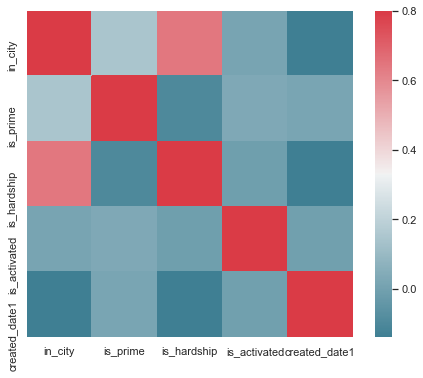

In [32]:
#correlation matrix
corrmat = inputdata.corr()
f, ax = plt.subplots(figsize=(8,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corrmat, vmax=.8, square=True, cmap=cmap);

Text(0.5, 1.0, 'ChiSquare matrix')

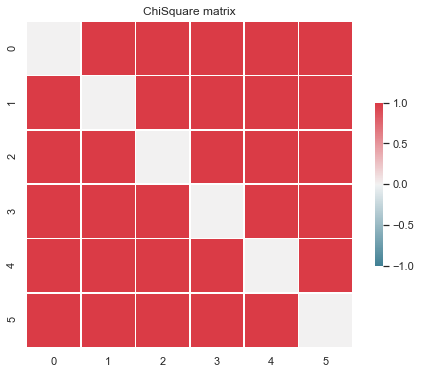

In [33]:
from scipy.stats import chisquare
f, ax = plt.subplots(figsize=(8,6))
inputdata1 = inputdata.drop(columns=['location_in_query','campaign_state','is_activated'])
inputdata1=inputdata1.apply(lambda x : pd.factorize(x)[0])+1
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(pd.DataFrame([chisquare(inputdata1[x].values,f_exp=inputdata1.values.T,axis=1)[0] for x in inputdata1]),\
            cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('ChiSquare matrix')
    

#### Get dummy variables for categorical variables

In [34]:
#dtrain= pd.get_dummies(inputdata.loc[:, train.columns != 'is_activated'],drop_first=True)
cat_cols = ['location_in_query','platform','campaign_state','category_debt_type']
model_data = pd.get_dummies(inputdata, prefix=cat_cols, columns=cat_cols)
for col in model_data.select_dtypes(include=['uint8']):
    model_data[col]=model_data[col].astype(bool)
for col in model_data.select_dtypes(include=['int64']):
    model_data[col]=model_data[col].astype(bool)
print(model_data.info())
for col in model_data.columns:
    print(model_data[col].describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94194 entries, 0 to 94193
Columns: 288 entries, in_city to category_debt_type_mortgage_refi
dtypes: bool(284), int64(4)
memory usage: 28.4 MB
None
count    94194.000000
mean         0.506911
std          0.499955
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: in_city, dtype: float64
count    94194.000000
mean         0.021604
std          0.145389
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: is_prime, dtype: float64
count    94194.000000
mean         0.300093
std          0.458301
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: is_hardship, dtype: float64
count     94194
unique        2
top       False
freq      87407
Name: is_activated, dtype: object
count    9.419400e+04
mean     2.017407e+07
std      4.147773e+03
min      2.01712

In [35]:
#Drop dummy variables which are redundant.
model_data = model_data.drop(columns = ['location_in_query_others','platform_undefined platform','campaign_state_others','category_debt_type_Missing'])

In [36]:
#Check for missing values
total = model_data.isnull().sum().sort_values(ascending=False)
percent = (model_data.isnull().sum()/model_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
in_city,0,0.0
location_in_query_riverside,0,0.0
location_in_query_saint petersburg,0,0.0
location_in_query_saint paul,0,0.0
location_in_query_saint louis,0,0.0
...,...,...
campaign_state_wi,0,0.0
campaign_state_wa,0,0.0
campaign_state_va,0,0.0
campaign_state_tx,0,0.0


In [37]:
#Split the data into development and Out of time validation data
model_data_dev = model_data[model_data['created_date1']<= 20180105]
model_data_otv= model_data[model_data['created_date1']>= 20180106]

print(model_data_dev.shape,model_data_otv.shape)


(75265, 284) (18929, 284)


In [38]:
X = model_data_dev.drop(columns = ['is_activated','created_date1'])
y = model_data_dev['is_activated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_otv = model_data_otv.drop(columns = ['is_activated','created_date1'])
y_otv = model_data_otv['is_activated']

In [39]:
print(X_train.shape, X_test.shape, X_otv.shape, y_train.shape, y_test.shape, y_otv.shape )

(60212, 282) (15053, 282) (18929, 282) (60212,) (15053,) (18929,)


In [40]:
len(y)

75265

In [41]:
print(y_train)

93701    False
30327    False
63475    False
51653    False
66532    False
         ...  
46577    False
7894     False
68732    False
1048     False
19841    False
Name: is_activated, Length: 60212, dtype: bool


In [42]:
#corrmat = X.corr()
#f, ax = plt.subplots(figsize=(15,12))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
#sns.heatmap(corrmat, vmax=.8, square=True,cmap=cmap);

### Model Development

#### Algorithm Selection

For this classification study, XGBoost was considered since this algorithm is widely popular and consistently outperforms other classification problems. It also offers some level of transparency when compared to neural networks. 

If time permits, other classification methods such as Randomforest, Logistic Regression, Naives Bayes can be considered and an ensemble voter can be created to select the best outcome.

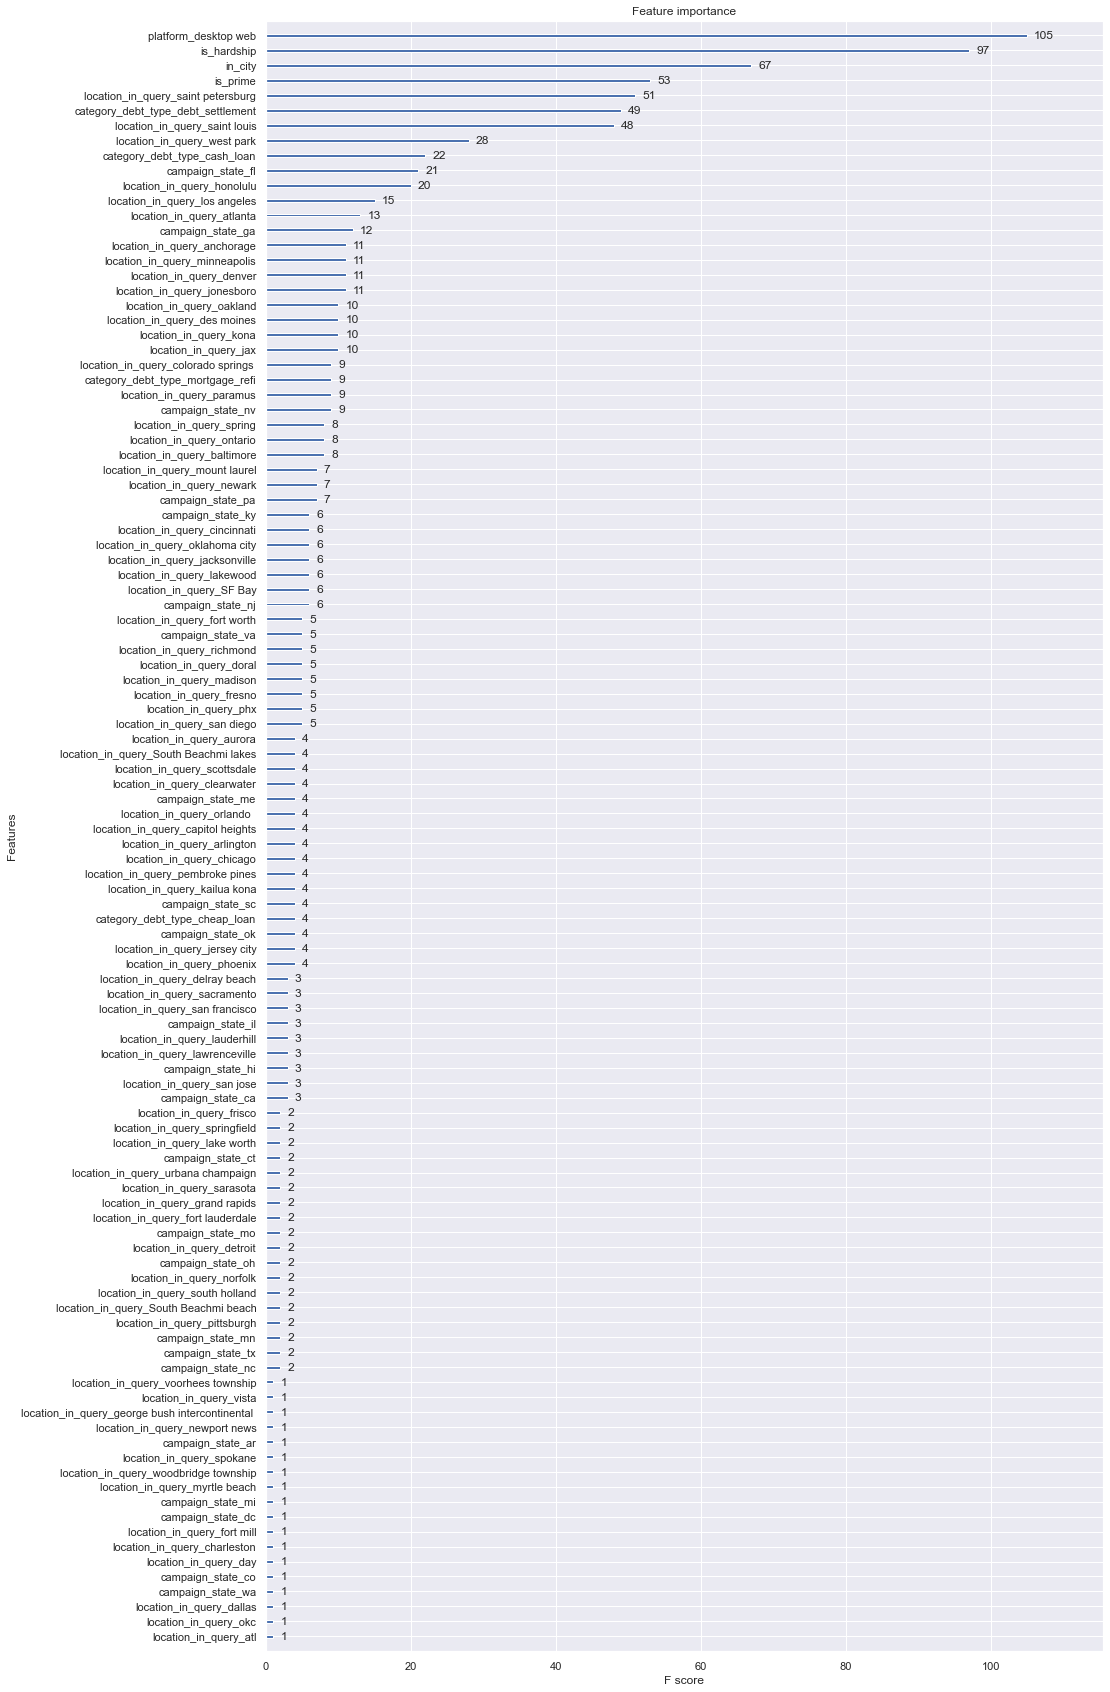


Model Report
Accuracy Train: 0.7519
AUC Score Train: 0.644526
F1 Score Train: 0.183002

Model Report
Accuracy Test: 0.749
AUC Score Test: 0.622616
F1 Score Test: 0.169670

Model Report
Accuracy OTV: 0.6997
AUC Score OTV: 0.580961
F1 Score OTV: 0.145498


In [43]:
#By default the algorightms have a probability treshold of 0.5, 
#but since this is a weak model the probability is set to 0.092 after some trials
prob_pred_threshold = 0.092 

xg_cl = xgb.XGBClassifier(objective="binary:logistic",n_estimators = 200, seed =27)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_train)
accuracy = accuracy_score(y_train, preds)
sns.set(rc={'figure.figsize':(15,30)})
plot_importance(xg_cl)
plt.show()

train_predprob = xg_cl.predict_proba(X_train)[:,1]
train_predictions= (train_predprob > prob_pred_threshold) 
        
#Print model report:
print ("\nModel Report")
print ("Accuracy Train: %.4g" % metrics.accuracy_score(y_train.values, train_predictions))
print ("AUC Score Train: %f" % metrics.roc_auc_score(y_train, train_predprob))
print ("F1 Score Train: %f" % metrics.f1_score(y_train.values, train_predictions))

test_predprob = xg_cl.predict_proba(X_test)[:,1]
test_predictions= (test_predprob > prob_pred_threshold) 
        
#Print model report:
print ("\nModel Report")
print ("Accuracy Test: %.4g" % metrics.accuracy_score(y_test.values, test_predictions))
print ("AUC Score Test: %f" % metrics.roc_auc_score(y_test, test_predprob))
print ("F1 Score Test: %f" % metrics.f1_score(y_test.values, test_predictions))

otv_predprob = xg_cl.predict_proba(X_otv)[:,1]
otv_predictions= (otv_predprob > prob_pred_threshold) 
        
#Print model report:
print ("\nModel Report")
print ("Accuracy OTV: %.4g" % metrics.accuracy_score(y_otv.values, otv_predictions))
print ("AUC Score OTV: %f" % metrics.roc_auc_score(y_otv, otv_predprob))
print ("F1 Score OTV: %f" % metrics.f1_score(y_otv.values, otv_predictions))
#feat_imp = pd.Series(xg_cl.booster().get_fscore()).sort_values(ascending=False)
#feat_imp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')

In [44]:
print('Confusion Matrix')
print('='*60)
print(confusion_matrix(y_test,test_predictions),"\n")
print('Classification Report')
print('='*60)
print(classification_report(y_test,test_predictions),"\n")
print('AUC-ROC')
print('='*60)
print(roc_auc_score(y_test, test_predprob))
 
report = classification_report(y_test,test_predictions, target_names=['class 0', 'class 1'],output_dict=dict)
print(report['class 0'])

Confusion Matrix
[[10889  3077]
 [  701   386]] 

Classification Report
              precision    recall  f1-score   support

       False       0.94      0.78      0.85     13966
        True       0.11      0.36      0.17      1087

    accuracy                           0.75     15053
   macro avg       0.53      0.57      0.51     15053
weighted avg       0.88      0.75      0.80     15053
 

AUC-ROC
0.6226164185567762
{'precision': 0.9395168248490078, 'recall': 0.7796792209652013, 'f1-score': 0.852167788386289, 'support': 13966}


In [45]:
model_data_dev["activation_prob"] = xg_cl.predict_proba(X)[:, 1]

In [46]:
model_data_dev

,in_city,is_prime,is_hardship,is_activated,created_date1,location_in_query_Denverver,location_in_query_SF Bay,location_in_query_South Beach,location_in_query_South Beachmi,location_in_query_South Beachmi beach,...,campaign_state_tx,campaign_state_ut,campaign_state_va,campaign_state_wa,campaign_state_wi,category_debt_type_cash_loan,category_debt_type_cheap_loan,category_debt_type_debt_settlement,category_debt_type_mortgage_refi,activation_prob
0,1,0,0,True,20171227,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,0.085199
2,1,0,0,True,20171215,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.134910
4,0,0,0,False,20171220,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,0.033094
5,0,0,0,True,20171216,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,0.100881
7,0,0,0,True,20171222,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.067694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94188,0,0,0,False,20171223,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.118414
94189,1,0,0,False,20171222,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.143910
94190,1,0,1,False,20171226,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.016079
94192,0,0,0,False,20171219,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0.133756


In [47]:
activations = model_data_dev[model_data_dev['is_activated'] == 1]
no_activations = model_data_dev[model_data_dev['is_activated'] == 0]

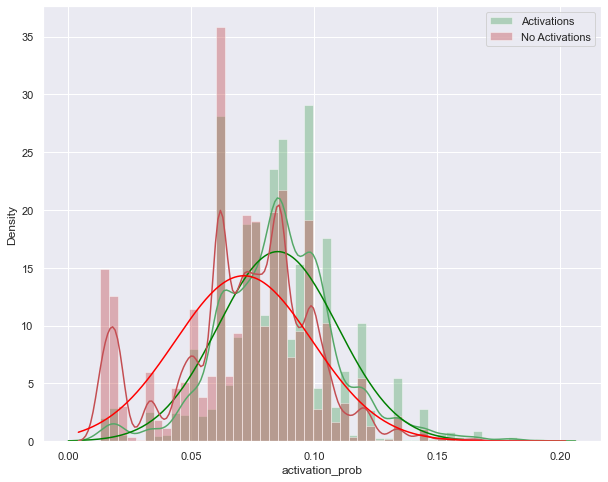

In [48]:
#Plot the distribution of the probability of activation for each prediction class.
#It is evident that there isn't significant separation between Activation and non-activation.
plt.figure(figsize = (10, 8))
sns.distplot(activations['activation_prob'], label = 'Activations', fit_kws={"color":"green"},color='g', fit=norm, )
sns.distplot(no_activations['activation_prob'], label = 'No Activations', fit_kws={"color":"red"}, color='r',fit=norm)
plt.legend()

In [49]:
score_df = model_data.drop(columns = ['created_date1','is_activated'])
score_df

,in_city,is_prime,is_hardship,location_in_query_Denverver,location_in_query_SF Bay,location_in_query_South Beach,location_in_query_South Beachmi,location_in_query_South Beachmi beach,location_in_query_South Beachmi garDenvers,location_in_query_South Beachmi lakes,...,campaign_state_tn,campaign_state_tx,campaign_state_ut,campaign_state_va,campaign_state_wa,campaign_state_wi,category_debt_type_cash_loan,category_debt_type_cheap_loan,category_debt_type_debt_settlement,category_debt_type_mortgage_refi
0,1,0,0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
1,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,0,0,0,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94189,1,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
94190,1,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
94191,1,0,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
94192,0,0,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [50]:
model_data1= model_data
model_data1["activation_prob"] = xg_cl.predict_proba(score_df)[:, 1]
model_data1['group_10'] = pd.qcut(model_data1['activation_prob'], q=10,labels=None)
model_data1['group_10'].value_counts()
#pd.pivot_table(model_data1, index='group_10', values=['activation_prob','is_activated'],aggfunc=['count','sum','mean'])

(0.0523, 0.0621]                  12516
(0.0826, 0.0866]                  10781
(0.0956, 0.105]                   10748
(0.012199999999999999, 0.0331]    10745
(0.0694, 0.0769]                  10383
(0.0769, 0.0826]                   8151
(0.0331, 0.0523]                   8111
(0.105, 0.252]                     8082
(0.0866, 0.0956]                   8064
(0.0621, 0.0694]                   6613
Name: group_10, dtype: int64

In [51]:
for i in np.arange(0.08, 0.1, 0.001):
    print('---------------------------------')
    print(i)
    train_predprob = xg_cl.predict_proba(X_train)[:,1]
    train_predictions= (train_predprob > i) 

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy Train: %.4g" % metrics.accuracy_score(y_train.values, train_predictions))
    print ("AUC Score Train: %f" % metrics.roc_auc_score(y_train, train_predprob))
    print ("F1 Score OTV: %f" % metrics.f1_score(y_train.values, train_predictions))

    test_predprob = xg_cl.predict_proba(X_test)[:,1]
    test_predictions= (test_predprob > i) 

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy OTV: %.4g" % metrics.accuracy_score(y_test.values, test_predictions))
    print ("AUC Score OTV: %f" % metrics.roc_auc_score(y_test, test_predprob))
    print ("F1 Score OTV: %f" % metrics.f1_score(y_test.values, test_predictions))

    otv_predprob = xg_cl.predict_proba(X_otv)[:,1]
    otv_predictions= (otv_predprob > i) 

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy OTV: %.4g" % metrics.accuracy_score(y_otv.values, otv_predictions))
    print ("AUC Score OTV: %f" % metrics.roc_auc_score(y_otv, otv_predprob))
    print ("F1 Score OTV: %f" % metrics.f1_score(y_otv.values, otv_predictions))
    print('----------------------------------')
    

---------------------------------
0.08

Model Report
Accuracy Train: 0.5855
AUC Score Train: 0.644526
F1 Score OTV: 0.177004

Model Report
Accuracy OTV: 0.5852
AUC Score OTV: 0.622616
F1 Score OTV: 0.172542

Model Report
Accuracy OTV: 0.5267
AUC Score OTV: 0.580961
F1 Score OTV: 0.149919
----------------------------------
---------------------------------
0.081

Model Report
Accuracy Train: 0.5899
AUC Score Train: 0.644526
F1 Score OTV: 0.177548

Model Report
Accuracy OTV: 0.5895
AUC Score OTV: 0.622616
F1 Score OTV: 0.173378

Model Report
Accuracy OTV: 0.5335
AUC Score OTV: 0.580961
F1 Score OTV: 0.150308
----------------------------------
---------------------------------
0.082

Model Report
Accuracy Train: 0.6103
AUC Score Train: 0.644526
F1 Score OTV: 0.178041

Model Report
Accuracy OTV: 0.6092
AUC Score OTV: 0.622616
F1 Score OTV: 0.171992

Model Report
Accuracy OTV: 0.5603
AUC Score OTV: 0.580961
F1 Score OTV: 0.150628
----------------------------------
--------------------------

Random: ROC AUC=0.500
XGB: ROC AUC Train=0.645
XGB: ROC AUC Test=0.623
XGB: ROC AUC OTV=0.581


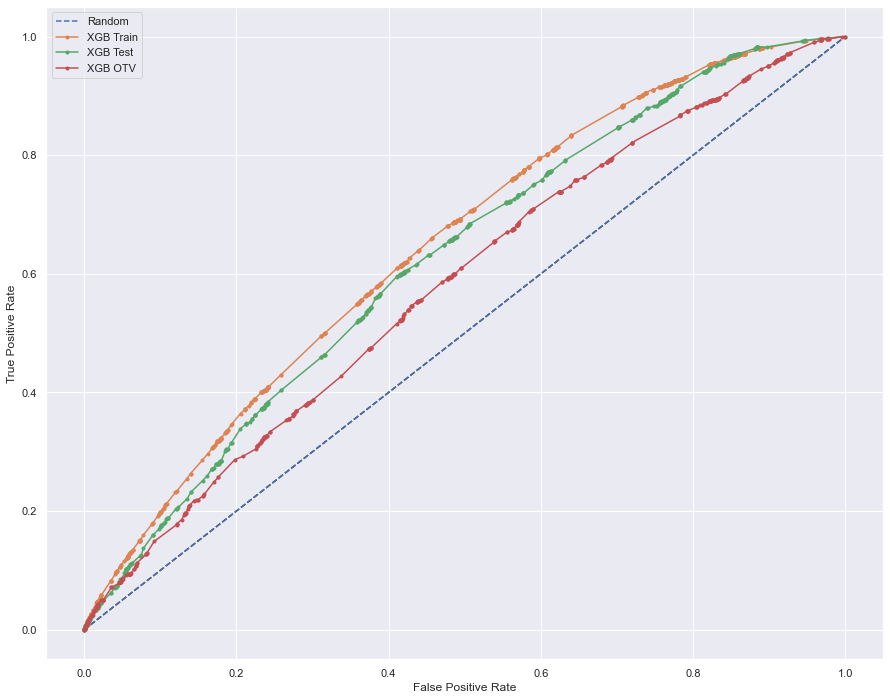

In [52]:
# predict probabilities
lr_probs = xg_cl.predict_proba(X_train)
lr_probs_test = xg_cl.predict_proba(X_test)
lr_probs_otv = xg_cl.predict_proba(X_otv)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_train))]
ns_probs_test = [0 for _ in range(len(y_test))]
ns_probs_otv = [0 for _ in range(len(y_otv))]
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
lr_probs_test = lr_probs_test[:, 1]
lr_probs_otv = lr_probs_otv[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
lr_auc_test = roc_auc_score(y_test, lr_probs_test)
lr_auc_otv = roc_auc_score(y_otv, lr_probs_otv)
# summarize scores
print('Random: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC Train=%.3f' % (lr_auc))
print('XGB: ROC AUC Test=%.3f' % (lr_auc_test))
print('XGB: ROC AUC OTV=%.3f' % (lr_auc_otv))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
lr_fpr_test, lr_tpr_test, _ = roc_curve(y_test, lr_probs_test)
lr_fpr_otv, lr_tpr_otv, _ = roc_curve(y_otv, lr_probs_otv)

sns.set(rc={'figure.figsize':(15,12)})
# plot the roc curve for the model
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGB Train')
plt.plot(lr_fpr_test, lr_tpr_test, marker='.', label='XGB Test')
plt.plot(lr_fpr_otv, lr_tpr_otv, marker='.', label='XGB OTV')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [60]:
import itertools
from sklearn.metrics import roc_curve, auc, precision_recall_curve,roc_auc_score, log_loss, \
accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.2f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.2f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    no_skill_text = 'no skill'
    ax.legend([train_text, test_text, no_skill_text])
    
def plot_prec_rec(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_score_train = precision_score(y_train, y_train_pred_labels)
    recall_score_train = recall_score(y_train, y_train_pred_labels)
    f1_score_train = f1_score(y_train, y_train_pred_labels)
  
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
    precision_score_test = precision_score(y_test, y_test_pred_labels)
    recall_score_test = recall_score(y_test, y_test_pred_labels)
    f1_score_test = f1_score(y_test, y_test_pred_labels)

    ax.plot(recall_train, precision_train)
    ax.plot(recall_test, precision_test)

    no_skill = len(y_train[y_train==1]) / len(y_train)
    ax.plot([0, 1], [no_skill, no_skill], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    
    train_text = 'train precision = {:.2f}, recall = {:.2f}, f1 = {:.2f}'.format(precision_score_train, recall_score_train, f1_score_train)
    test_text = 'test precision = {:.2f}, recall = {:.2f}, f1 = {:.2f}'.format(precision_score_test, recall_score_test, f1_score_test)
    no_skill_text = 'no skill'
    ax.legend([train_text, test_text, no_skill_text])

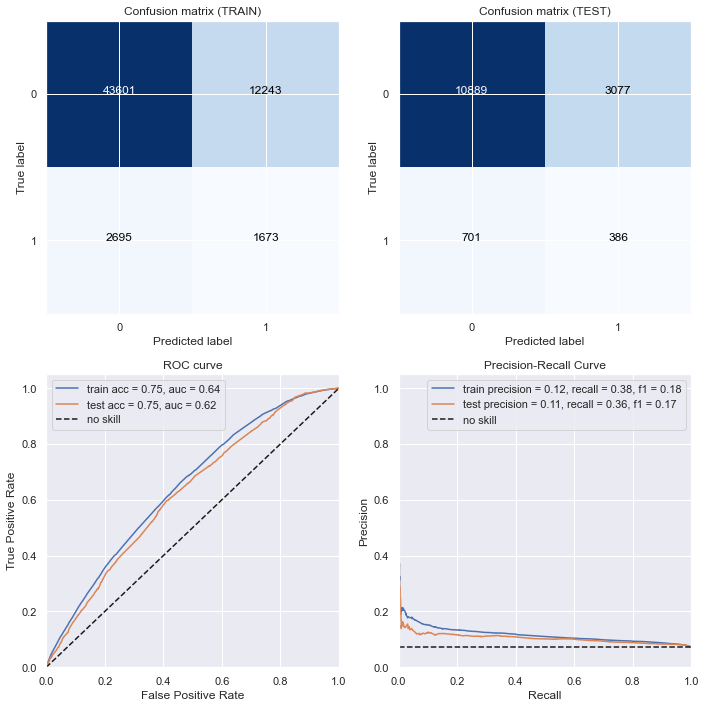

In [73]:
y_train_pred = xg_cl.predict_proba(X_train)[:,1]
y_test_pred = xg_cl.predict_proba(X_test)[:,1]
y_otv_pred = xg_cl.predict_proba(X_otv)[:,1]

threshold = 0.092
   
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(10,10)

plot_cm(ax1,  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax2,  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax3, y_train, y_train_pred, y_test, y_test_pred, threshold)
plot_prec_rec(ax4, y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

## Comparing the performance of various classification algorithms and sampling methods

In [53]:
model_name = []
resample = []
precision = []
precision_0 =[]
precision_1 =[]
recall = []
recall_0 = []
recall_1 = []
F1score = []
F1score_0 = []
F1score_1 = []
AUCROC = []

In [54]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)[:,1]
    y_pred=(y_prob > 0.092)
    y_pred=pd.Series(y_pred)
    y_pred = y_pred.astype('bool')
    y_pred.shape  
    
    report = classification_report(y_test,y_pred, target_names=['class 0', 'class 1'],output_dict=dict)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob))
          
    model_name.append(algo)
    precision.append(precision_score(y_test,y_pred))
    precision_0.append(report['class 0']['precision'])
    precision_1.append(report['class 1']['precision'])
    recall.append(recall_score(y_test,y_pred))
    recall_0.append(report['class 0']['recall'])
    recall_1.append(report['class 1']['recall'])
    F1score.append(f1_score(y_test,y_pred))
    F1score_0.append(report['class 0']['f1-score'])
    F1score_1.append(report['class 1']['f1-score'])
    AUCROC.append(roc_auc_score(y_test, y_prob))
    resample.append(sampling)

In [55]:
classifiers = {"Logistic" : LogisticRegression(n_jobs=-1),
                "CatBoost" : CatBoostClassifier(verbose=False),
               "LGBM" : LGBMClassifier(n_jobs=-1),
               "XGBoost" : xgb.XGBClassifier(n_jobs=-1),
               "CatBoost Balanced" : CatBoostClassifier(verbose=False, auto_class_weights="Balanced"),
               "RandomForest" : RandomForestClassifier(n_jobs=-1)
              }
for classifier in classifiers:
    model = classifiers[classifier]
    model.fit(X_train, y_train)
    print('='*60)
    print (classifier, "imbalanced")
    print('='*60)
    test_eval(model, X_test, y_test, classifier, "None")

Logistic imbalanced
Confusion Matrix
[[10146  3820]
 [  629   458]] 

Classification Report
              precision    recall  f1-score   support

       False       0.94      0.73      0.82     13966
        True       0.11      0.42      0.17      1087

    accuracy                           0.70     15053
   macro avg       0.52      0.57      0.50     15053
weighted avg       0.88      0.70      0.77     15053
 

AUC-ROC
0.6198347254424301
CatBoost imbalanced
Confusion Matrix
[[10410  3556]
 [  650   437]] 

Classification Report
              precision    recall  f1-score   support

       False       0.94      0.75      0.83     13966
        True       0.11      0.40      0.17      1087

    accuracy                           0.72     15053
   macro avg       0.53      0.57      0.50     15053
weighted avg       0.88      0.72      0.78     15053
 

AUC-ROC
0.6226177689252161
LGBM imbalanced
Confusion Matrix
[[10301  3665]
 [  639   448]] 

Classification Report
              pr

In [56]:
classifiers = {"Logistic" : LogisticRegression(n_jobs=-1),
               "CatBoost" : CatBoostClassifier(verbose=False),
              "LGBM" : LGBMClassifier(n_jobs=-1),
              "XGBoost" :xgb.XGBClassifier(n_jobs=-1),
               "RandomForest" : RandomForestClassifier(n_jobs=-1)
              }

sampling_methods = {"SMOTE" : SMOTE(),
                    "SMOTEENN" : SMOTEENN(),
                    "TomekLinks": TomekLinks(),
                    "NearMiss" : NearMiss()
                   }
for sampling_method in sampling_methods:
    method = sampling_methods[sampling_method]
    X_resamp, y_resamp = method.fit_resample(X_train, y_train)
    for classifier in classifiers:           
        model = classifiers[classifier]
        model.fit(X_resamp, y_resamp)
        print('='*60)
        print (classifier, sampling_method)
        print('='*60)
        test_eval(model, X_test, y_test, classifier, sampling_method)

Logistic SMOTE
Confusion Matrix
[[  143 13823]
 [   11  1076]] 

Classification Report
              precision    recall  f1-score   support

       False       0.93      0.01      0.02     13966
        True       0.07      0.99      0.13      1087

    accuracy                           0.08     15053
   macro avg       0.50      0.50      0.08     15053
weighted avg       0.87      0.08      0.03     15053
 

AUC-ROC
0.6105810786901189
CatBoost SMOTE
Confusion Matrix
[[  411 13555]
 [   24  1063]] 

Classification Report
              precision    recall  f1-score   support

       False       0.94      0.03      0.06     13966
        True       0.07      0.98      0.14      1087

    accuracy                           0.10     15053
   macro avg       0.51      0.50      0.10     15053
weighted avg       0.88      0.10      0.06     15053
 

AUC-ROC
0.6163515982631496
LGBM SMOTE
Confusion Matrix
[[  214 13752]
 [   12  1075]] 

Classification Report
              precision    reca

In [57]:
clf_eval_df = pd.DataFrame({'model':model_name,
                            'resample':resample,
                            'precision':precision,
                            'precision_0':precision_0,
                            'precision_1':precision_1,
                            'recall':recall,
                            'recall_0':recall_0,
                            'recall_1':recall_1,
                            'f1-score':F1score,
                            'f1-score_0':F1score_0,
                            'f1-score_1':F1score_1,
                            'AUC-ROC':AUCROC})
clf_eval_df

,model,resample,precision,precision_0,precision_1,recall,recall_0,recall_1,f1-score,f1-score_0,f1-score_1,AUC-ROC
0,Logistic,None,0.107059,0.941624,0.107059,0.421343,0.726479,0.421343,0.170736,0.820177,0.170736,0.619835
1,CatBoost,None,0.109442,0.941230,0.109442,0.402024,0.745382,0.402024,0.172047,0.831935,0.172047,0.622618
2,LGBM,None,0.108923,0.941590,0.108923,0.412144,0.737577,0.412144,0.172308,0.827190,0.172308,0.624990
3,XGBoost,None,0.112200,0.936743,0.112200,0.284269,0.824932,0.284269,0.160896,0.877289,0.160896,0.619659
4,CatBoost Balanced,None,0.072518,0.947598,0.072518,0.988960,0.015538,0.988960,0.135127,0.030574,0.135127,0.620225
5,RandomForest,None,0.106054,0.942339,0.106054,0.441582,0.710296,0.441582,0.171032,0.810027,0.171032,0.612852
6,Logistic,SMOTE,0.072220,0.928571,0.072220,0.989880,0.010239,0.989880,0.134618,0.020255,0.134618,0.610581
7,CatBoost,SMOTE,0.072719,0.944828,0.072719,0.977921,0.029429,0.977921,0.135371,0.057079,0.135371,0.616352
8,LGBM,SMOTE,0.072503,0.946903,0.072503,0.988960,0.015323,0.988960,0.135101,0.030158,0.135101,0.622546
9,XGBoost,SMOTE,0.072212,0.000000,0.072212,1.000000,0.000000,1.000000,0.134696,0.000000,0.134696,0.616663


Rank the population by probability of activation and divide the population into 10 equal groups

The probabilities are clustered around certain values. The distribution can be made better with the use of features which are continous

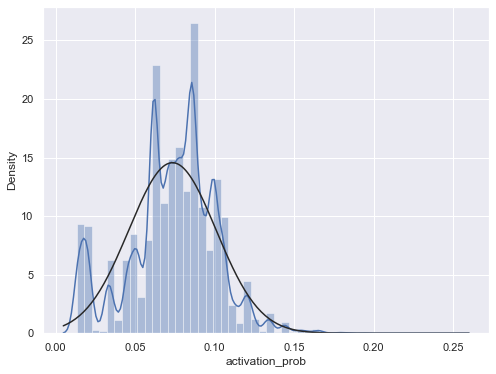

<Figure size 1080x864 with 0 Axes>

In [58]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(model_data['activation_prob'], fit=norm);
fig = plt.figure()

### Export model

In [59]:
import pickle
# save model to file
pickle.dump(xg_cl, open('Clicks_Activation_XGB_Model.dat', 'wb'))